# Homework 5 - Question 2

In [90]:
import pycountry
import pandas as pd
import numpy as np
import os
import seaborn as sns
import datetime
import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [91]:
filename = os.path.join('hillary-clinton-emails','Emails.csv')
df_email_initial = pd.read_csv(filename)
df_email_initial.head(2)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",UNCLASSIFIED\r\nU.S. Department of State\r\nCa...


In [92]:
df_email = df_email_initial
# df_email = df_email_initial[["ExtractedSubject", "ExtractedBodyText"]]
df_email = df_email.dropna(axis=0, how='any', subset=['ExtractedBodyText'])
df_email.head(2)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...


In [93]:
countriesName = list(x.name for x in list(pycountry.countries))
results = pd.DataFrame(countriesName, columns=['country'])
results['sentiment'] = ""
results['frequency'] = ""
results.head(5)

,country,sentiment,frequency
0,Aruba,,
1,Afghanistan,,
2,Angola,,
3,Anguilla,,
4,Åland Islands,,


In [94]:
bad_countries_abbrev = ["RE", "FM", "TV", "AL", "AQ", "LA", "BEN", "and", "is", 'my', 'no', 'to', 'are', 'in', 'so', 'at',
                       'as', 'be', 'by', 'can', 'it', 'am', 'as', 'do', 'us', 'me', 'pm', 'ago', 'arm', 'mn', 'nor']
bad_countries_abbrev = [abb.lower() for abb in bad_countries_abbrev]

In [95]:
def formatCountry(word):
    return (' ' + word + ' ').lower()

def makeCountryTable(country):
    countryArr = [country.name.lower()]
    if(country.alpha_2.lower() not in bad_countries_abbrev):
        countryArr.append(formatCountry(country.alpha_2))
    if(country.alpha_3.lower() not in bad_countries_abbrev):
        countryArr.append(formatCountry(country.alpha_3))
    if hasattr(country, 'official_name'):
        countryArr.append(country.official_name.lower())
    ## We add the name "Syria" that is common
    if country.name == 'Syrian Arab Republic':
        countryArr.append('syria')
    
    return countryArr    

In [96]:
countryNamesAbbrev = list(makeCountryTable(x) for x in list(pycountry.countries))

Sentiment score computations: Vader and liu hu lexicon

In [97]:
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank

In [98]:
def vader_sentiment_computation(text):
    """
    Function from https://github.com/nltk/nltk/blob/develop/nltk/sentiment/util.py
    Output polarity scores for a text using Vader approach.
    :param text: a text whose polarity has to be evaluated.
    """
    vader_analyzer = SentimentIntensityAnalyzer()
    return vader_analyzer.polarity_scores(text).get('compound')

In [99]:
def computation_liu_hu_lexicon(text):
    """
    Function inspiration from https://github.com/nltk/nltk/blob/develop/nltk/sentiment/util.py
    Helper function to compute the number of positive word, of negative words and of neutrals words.
    Output: (Number of positive words, number of negative words, number of neutral words)
    :param text: a text whose polarity has to be classified.
    """

    tokenizer = treebank.TreebankWordTokenizer()
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(text)]
    pos_words = 0
    neg_words = 0
    neut_words = 0
    
    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
#             print('positive: ',word)
            pos_words += 1
        elif word in opinion_lexicon.negative():
#             print('negative: ', word)
            neg_words += 1
        else:
            neut_words += 1

    print('Positive words: ', pos_words)
    print('Negative words: ', neg_words)
    print('Neutral words: ', neut_words)
    return (pos_words, neg_words, neut_words)

In [100]:
def liu_hu_lexicon_absolute(pos_words, neg_words):
    """
    Sentiment classification using Liu and Hu opinion lexicon.
    This function compute the liu hu scores by taking the majority voting.
    If the majority of the words are positive, the score will be 1, if it
    is negative, the score will be -1, otherwise the score will be 0.
    :param pos_words: The number of positive words in a text
    :param neg_words: The number of negative words in a text
    """

    if pos_words > neg_words:
        return 1
    elif pos_words < neg_words:
        return -1
    elif pos_words == neg_words:
        return 0

In [101]:
def liu_hu_lexicon_relative(pos_words, neg_words):
    """
    Sentiment classification using Liu and Hu opinion lexicon.
    This function compute the liu hu scores by taking the number of 
    positive words over the total number of positive and negative words. Therefore it will
    ponderate the score with the total number of negative and positive words
    and output a continuous score between -1 and 1. -1 beeing when
    there is only negative words and 1 when there is only positive words.
    :param pos_words: The number of positive words in a text
    :param neg_words: The number of negative words in a text
    """

    if pos_words == 0 and neg_words == 0:
        return -1
    else:
        return pos_words / (pos_words + neg_words)

In [102]:
def liu_hu_lexicon_neutral_ponderated(pos_words, neg_words, neut_words):
    """
    Sentiment classification using Liu and Hu opinion lexicon.
    This function compute the liu hu scores by ponderating the number of positive
    words with the total number of positive and negative words. It will then ponderate this 
    score with the total number of neutral words.
    :param pos_words: The number of positive words in a text
    :param neg_words: The number of negative words in a text
    :param neut_words: The number of neutral words in a text
    """

    if pos_words == 0 and neg_words == 0:
        return -1
    else:
        return (pos_words / ( neut_words + pos_words + neg_words))

In [103]:
def execute_liu_hu_lexicon_tests(text):
    """
    Input: A text on which to execute the lexicon task
    Output: The results of the three lexicon functions
    """
    (pos_words, neg_words, neut_words) = computation_liu_hu_lexicon(text)
    absolute = liu_hu_lexicon_absolute(pos_words, neg_words)
    relative = liu_hu_lexicon_relative(pos_words, neg_words)
    ponderated = liu_hu_lexicon_neutral_ponderated(pos_words, neg_words, neut_words)
    return (absolute, relative, ponderated)

Function to analyze sentiment over the data:

In [104]:
## Initialize dictionnaries to store sentiment
vader_sentiment_dict = {}
liu_hu_absolute_dict = {}
liu_hu_relative_dict = {}
liu_hu_ponderated_dict = {}

In [105]:
## Update a dictionary with the country as key and the result as value.
def update_sentiment_dict(country_name, dict_to_update, result):
    if(not dict_to_update.get(country_name)):
        dict_to_update[country_name] = [result]
    else:
        dict_to_update[country_name].append(result)

In [106]:
def analyzeSentimentInDf(row):
    emailContent = str(row.ExtractedBodyText).lower()
    foundCountryList = []
    
    ## Iteration over all countries
    for country in countryNamesAbbrev:
        foundCountry = False
        
        ## Iteration over all names for a specific country
        for abrev in country:
            if not foundCountry and abrev in emailContent:
                if len(foundCountryList) == 0:
                    print('------------------------------- EMAIL N0: ', row.Id, ' -------------------------------')
                    print('--------- COUNTRIES ---------')
                foundCountry = True
                foundCountryList.append(country[0])
                print(country[0], ': ',abrev)
    
    ## If we found at least one country name in email, we compute sentiment scores
    if len(foundCountryList) != 0:
        print('-----------------------------------')
        vader_score = vader_sentiment_computation(emailContent)
        (abs_lex_score, rel_lex_score, pond_lex_score) = execute_liu_hu_lexicon_tests(emailContent)
        
        ## Update dictionnaries containing scores:
        for f_country in foundCountryList:
            update_sentiment_dict(f_country, vader_sentiment_dict, vader_score)
            update_sentiment_dict(f_country, liu_hu_absolute_dict, abs_lex_score)
            if rel_lex_score != -1:
                update_sentiment_dict(f_country, liu_hu_relative_dict, rel_lex_score)
            if pond_lex_score != -1:
                update_sentiment_dict(f_country, liu_hu_ponderated_dict, pond_lex_score)  
                
        
        print('--------- SENTIMENT SCORE ---------')
        print('Vader score: ', vader_score)
        print('Absolute Lexicon score: ', abs_lex_score)
        print('Relative Lexicon score: ', rel_lex_score)
        print('Ponderated Lexicon score: ', pond_lex_score)

        print('--------- EMAIL CONTENT ---------')
        print(emailContent)

In [107]:
def aggregateSentimentInformation(sentiment_dict):
    resultDict = {}
    for country in sentiment_dict:
        resultDict[country] = np.mean(sentiment_dict[country])
    return resultDict

In [108]:
# sample_email = df_email.head(100)
sample_email = df_email
sample_email.apply(analyzeSentimentInDf, axis=1)
print('finished!')

------------------------------- EMAIL N0:  2  -------------------------------
--------- COUNTRIES ---------
libya :  libya
syrian arab republic :  syria
-----------------------------------
Positive words:  0
Negative words:  0
Neutral words:  41
--------- SENTIMENT SCORE ---------
Vader score:  0.0
Absolute Lexicon score:  0
Relative Lexicon score:  -1
Ponderated Lexicon score:  -1
--------- EMAIL CONTENT ---------
b6
thursday, march 3, 2011 9:45 pm
h: latest how syria is aiding qaddafi and more... sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
march 3, 2011
for: hillary
------------------------------- EMAIL N0:  5  -------------------------------
--------- COUNTRIES ---------
libya :  libya
syrian arab republic :  syria
-----------------------------------
Positive words:  0
Negative words:  0
Neutral words:  40
--------- SENTIMENT SCORE ---------
Vader score:  0.0
Absolute Lexicon score:  0
Relative Lexicon score:  -1
Ponderated Lexicon score:  -1

KeyboardInterrupt: 

## Aggregated sentiment tests

In [76]:
sns.set(style="whitegrid", color_codes=True)

def makePlotForSentimentDict(sentiment_dict, y_min= -1.1, y_max = 1.1):
    plot_row_lists = []
    for country in sentiment_dict:
        for val in sentiment_dict[country]:
            plot_row_lists.append({'country': country, 'sentiment': val})
    
    ## Order of columns in plot
    order = pd.Series(aggregateSentimentInformation(sentiment_dict)).sort_values().index
    
    plt.ylim(y_min, y_max)
    plot_df = pd.DataFrame(plot_row_lists)
    plot = sns.stripplot(x="country", y="sentiment", data = plot_df, order = order);
#     plot = sns.boxplot(x="country", y="sentiment", data = plot_df, order = order);
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    return plot

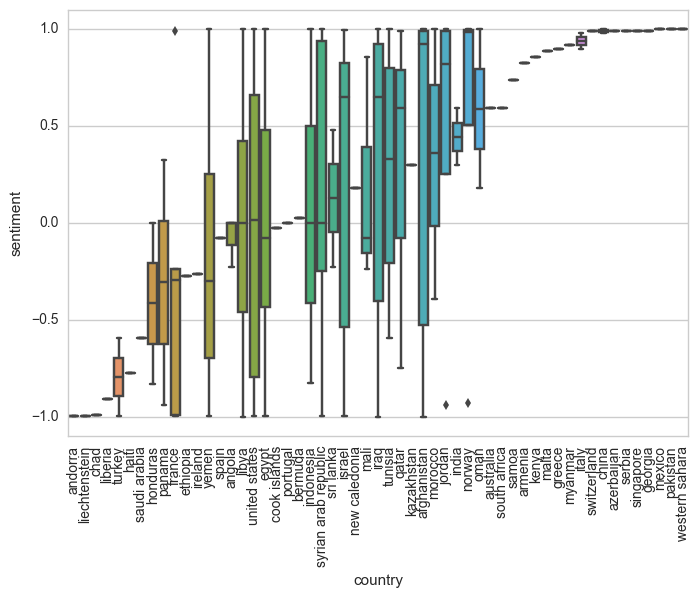

In [82]:
makePlotForSentimentDict(vader_sentiment_dict)

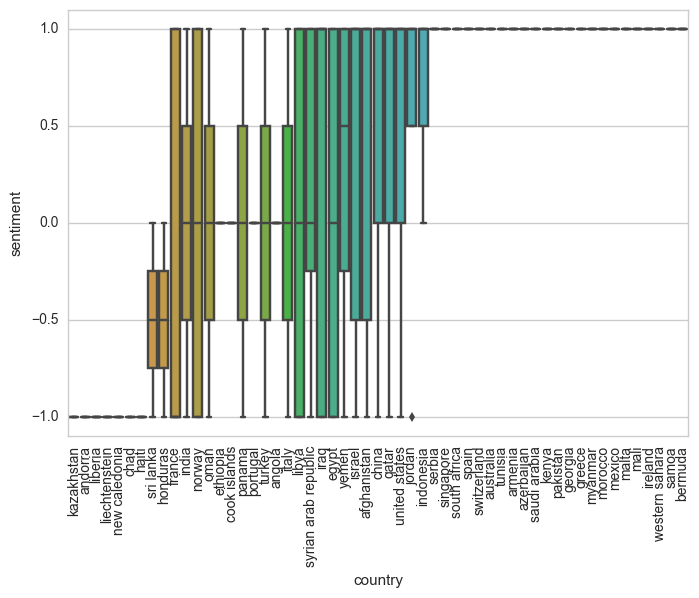

In [81]:
makePlotForSentimentDict(liu_hu_absolute_dict)

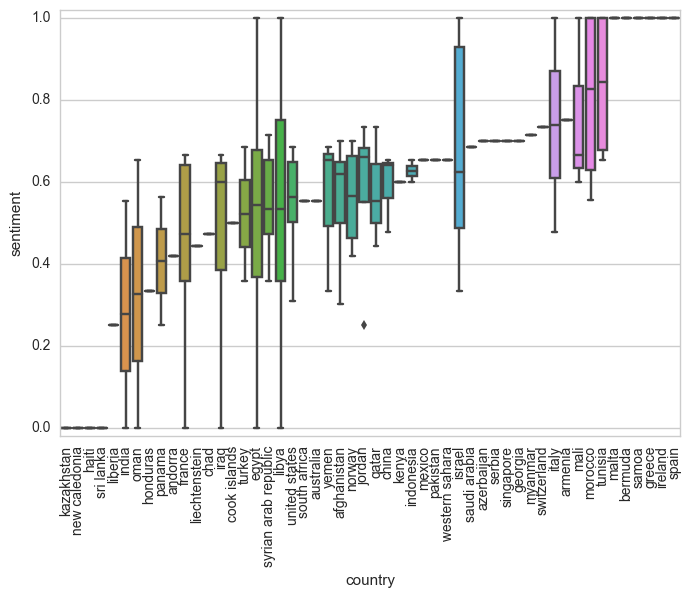

In [86]:
makePlotForSentimentDict(liu_hu_relative_dict, -0.02, 1.02)

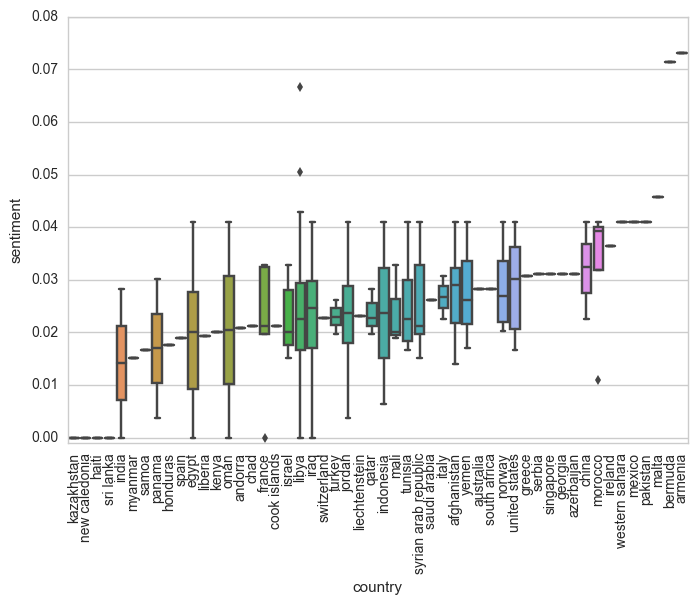

In [89]:
makePlotForSentimentDict(liu_hu_ponderated_dict, -0.001, 0.08)

# Other

In [ ]:
plot_row_lists = []
for country in vader_sentiment_dict:
    for val in vader_sentiment_dict[country]:
        plot_row_lists.append({'country': country, 'sentiment': val})
plot_row_lists[:3]

In [ ]:
vader_result = aggregateSentimentInformation(vader_sentiment_dict)
pd.Series(vader_result).sort_values().index

In [ ]:
vader_result = aggregateSentimentInformation(vader_sentiment_dict)
pd.DataFrame.from_dict(vader_result, orient='columns', index='a')
results_series = pd.Series(vader_sentiment_dict, name='sentiments_val')
results_series.index.name = 'country'
plot_df = pd.DataFrame(results_series.reset_index())
plot_df.sort_values('sentiments_val', inplace=True)
plot_df.head(2)
plot_df = pd.DataFrame(plot_row_lists)

In [ ]:
sns.set(style="whitegrid", color_codes=True)
tips = sns.load_dataset("tips")

In [ ]:
plot = sns.stripplot(x="country", y="sentiment", data=plot_df);
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plot

In [ ]:
tips

In [ ]:
x = ['a', 'b', 'c']
b = ['a'] if 'aa' in x else ''
[a if a is 'a' else 'b' for a in x]

In [ ]:
print('hey')

In [ ]:
nltk.download('opinion_lexicon')
nltk.download('vader_lexicon')

In [ ]:
from nltk.classify import NaiveBayesClassifier, MaxentClassifier
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import LinearSVC
import nltk.sentiment.util

naive_bayes = NaiveBayesClassifier.train
svm = SklearnClassifier(LinearSVC()).train
maxent = MaxentClassifier.train

nltk.sentiment.util.demo_vader_instance(df_email.ExtractedBodyText[13])

In [ ]:
nltk.sentiment.util.demo_liu_hu_lexicon(df_email.ExtractedBodyText[13], plot=True)

In [ ]:
def my_demo_liu_hu_lexicon(sentence, plot=False):
    """
    Basic example of sentiment classification using Liu and Hu opinion lexicon.
    This function simply counts the number of positive, negative and neutral words
    in the sentence and classifies it depending on which polarity is more represented.
    Words that do not appear in the lexicon are considered as neutral.
    :param sentence: a sentence whose polarity has to be classified.
    :param plot: if True, plot a visual representation of the sentence polarity.
    """
    from nltk.corpus import opinion_lexicon
    from nltk.tokenize import treebank

    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    neut_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]

    x = list(range(len(tokenized_sent))) # x axis for the plot
    y = []

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            print('positive: ',word)
            pos_words += 1
            y.append(1) # positive
        elif word in opinion_lexicon.negative():
            print('negative: ', word)
            neg_words += 1
            y.append(-1) # negative
        else:
            neut_words += 1
            y.append(0) # neutral
    print('Positive words: ', pos_words)
    print('Negative words: ', neg_words)
    print('Neutral words: ', neut_words)

    if pos_words > neg_words:
        print('Positive')
    elif pos_words < neg_words:
        print('Negative')
    elif pos_words == neg_words:
        print('Neutral')


In [ ]:
my_demo_liu_hu_lexicon(df_email.ExtractedBodyText[13])

In [ ]:
# df_email.ExtractedBodyText[13]

In [ ]:
pydic = {'Switzerland': {'CH':[0.2, 0.5, 1.5], 'Suisse': [1,2,3]}, 'Germany':{'GE': [2,2.1, 6, 8], 'Allemagne': [2]} }

In [ ]:
pydic.get('Switzerland').get('CH')

In [ ]:
pydic

In [ ]:
for a in pydic:
    print(pydic.get(a))

In [ ]:
if not pydic.get('Switzerlands'):
    pydic['Switzerlands'] = [2]
pydic

In [ ]:
testaaa = {'Switzerland': [0.2, 0.5, 1.5], 'Suisse': [1,2,3], 'Germany': [2,2.1, 6, 8], 'Allemagne': [2]}

In [ ]:
testaaa['aaa'] = [2]
testaaa

In [ ]:
update_sentiment_dict('key', testaaa, 25)
testaaa

In [ ]:
np.mean(testaaa['Germany'])

In [ ]:
(2 + 2.1 + 6 + 8)/4

# Old function:

In [ ]:
def analyzeSentimentInDfOLD(row):
    emailContent = str(row.ExtractedBodyText).lower()
#     if('syria' in emailContent):
#             if (row.ExtractedSubject):
#                 print("Subject: ",row.ExtractedSubject, "\n")
#             print(emailContent)
#             print('-----------------------------------------------------------------------------')
    foundCountryGlobal = False
    for country in countryNamesAbbrev:
        foundCountry = False
        for abrev in country:
            if not foundCountry and abrev in emailContent:
                if(not foundCountryGlobal):
                    print('------------------------------- EMAIL N0: ', row.Id, ' -------------------------------')
                    print('COUNTRIES:')
                foundCountry = True
                foundCountryGlobal = True
                print(country[0], ': ',abrev)
    if foundCountryGlobal:
        pass
        print('--------- EMAIL CONTENT ---------')

        print(emailContent)
#         if any(abrev in emailContent for abrev in country):
#             print(abrev)
#         print(emailContent)
#         if('9.11' in emailContent):
#             print(emailContent)
#             print('-----------------------------------------------------------------------------')
#             print('-----------------------------------------------------------------------------')

#         if any(abrev in emailContent for abrev in country):
#             print('hey')